In [1]:
#!/usr/bin/env python3

#%matplotlib inline
from zipfile import ZipFile
import itertools
import numpy as np
import pandas as pd
import os
import re
import multiprocessing as mp
from scipy.special import legendre
from matplotlib import pyplot as plt
from functools import partial
import numba


class PopulationParameters():
    def __init__(self):
        if "/home/users" in os.environ["HOME"]:
            # this condition filters, whether the script is executed on a server without 
            # the user having root rights, such as at the servers of Universität Kassel
            # solution from:
            # https://stackoverflow.com/questions/4906977/how-do-i-access-environment-variables-from-python/4907053#4907053
            self.pedigree_folder = os.environ["HOME"] + "/Doktorarbeit/Daten/vit/"
            self.milkrecording_folder = os.environ["HOME"] + "/Doktorarbeit/Daten/LKV SH"
        else:
            self.pedigree_folder = os.environ["HOME"] + "/Dokumente/Uni/Mitarbeiterstelle Witzenhausen/Daten/vit/"
            self.milkrecording_folder = os.environ["HOME"] + "/Dokumente/Uni/Mitarbeiterstelle Witzenhausen/Daten/LKV SH"
        self.pedigree_zip_files = [i for i in os.listdir(self.pedigree_folder) if ".zip" in i and ".directory" not in i]
        self.pedigree_csv_files = [i for i in os.listdir(self.pedigree_folder) if ".csv" in i and ".~lock" not in i and ".directory" not in i]
        self.milkrecording_csv = [i for i in os.listdir(self.milkrecording_folder) if ".csv" in i and ".~lock" not in i and ".directory" not in i]
        self.breed_code_path = "/".join(self.pedigree_folder.split("/")[:-2]) + "/Breed codes.csv"
        
    def pedigree_data(self, intermediate_saving=False, overwriting=False):
        breed_codes = pd.read_csv(
            self.breed_code_path, 
            usecols=["ADR-Num", "ZWS-Rasse", "Alpha-DEU", "Name"],
            index_col=0
        )
        breed_codes.index = np.int64(breed_codes.index)
        living_animals = pd.DataFrame()
        pedigree_ang = pd.DataFrame()
        pedigree_rdn = pd.DataFrame()
        pedigree_typed_ang = pd.DataFrame()
        pedigree_typed_rdn = pd.DataFrame()
        r_ebv = pd.DataFrame()
        l = self.pedigree_zip_files
        if overwriting is True:
            for f in self.pedigree_csv_files:
                os.remove(f"{self.pedigree_folder}/{f}")
        pattern_ebv = re.compile(r"^TYP_[a-zA-Z0-9]{3}_EBV_[aA-zZ0-9_]{1,}.zip$")
        pattern_lebend = re.compile(r"^lebend_[a-zA-Z0-9]{3}.zip")
        # this pattern does not catch the file with the full pedigree information
        
        pattern_typed = re.compile(r"^TYP_[A-Z]{3}_Abstg_[aA-zZ0-9_]{1,}.zip$")
        pattern_leb = re.compile(r"^leb_[A-Z]{3}_Abstg_[aA-zZ0-9_]{1,}.zip$")
        if mp.cpu_count() > 4:
            _processes = mp.cpu_count()/2
        else:
            _processes = mp.cpu_count()
        pattern_ang = re.compile(r"^[aA-zZ]{3}_ANG_Abstg_[aA-zZ0-9_]{1,}.zip$")
        pattern_rdn = re.compile(r"^[aA-zZ]{3}_RDN_Abstg_[aA-zZ0-9_]{1,}.zip$")
        for zf in l:
            # this loop does not require multiprocessing
            if pattern_lebend.match(zf):
                r = self.__preprocessed_pedigree_processing(zf, breed_codes)
                living_animals = pd.concat([living_animals,r], axis=0)
            if pattern_ebv.match(zf):
                r = self.__preprocessed_pedigree_processing(zf, breed_codes)
                r_ebv = pd.concat([r_ebv, r], axis=0, sort=False)
            if pattern_typed.match(zf) or pattern_leb.match(zf):
                with mp.Pool(processes=_processes) as pool2:
                    # this is now the pattern for the full pedigree
                    breed_cols = self.__columns(breed_cols=True)
                    pedigree_cols = self.__columns(pedigree_cols=True)
                    _index_cols = self.__columns(_index_cols=True)
                    c = _index_cols + pedigree_cols[2:] + breed_cols + ["\n"]
                    if intermediate_saving is True:
                        if pattern_leb.match(zf):
                            # please refer the solution to the file problem to the following link:
                            # https://stackoverflow.com/questions/16208206/confused-by-python-file-mode-w/23566951#23566951
                            if "Pedigree.csv" in self.pedigree_csv_files:
                                if pattern_ang.match(zf):
                                    _file = open(f"{self.pedigree_folder}/Pedigree ANG.csv", "a", encoding="utf-8")
                                if pattern_rdn.match(zf):
                                    _file = open(f"{self.pedigree_folder}/Pedigree RDN.csv", "a", encoding="utf-8")
                            else:
                                if pattern_ang.match(zf):
                                    _file = open(f"{self.pedigree_folder}/Pedigree ANG.csv", "w+", encoding="utf-8")
                                    _file.write(",".join(list(itertools.repeat("Pedigree", len(c))) + ["\n"]))
                                    _file.write(",".join(c))
                                if pattern_rdn.match(zf):
                                    _file = open(f"{self.pedigree_folder}/Pedigree RDN.csv", "w+", encoding="utf-8")
                                    _file.write(",".join(list(itertools.repeat("Pedigree", len(c))) + ["\n"]))
                                    _file.write(",".join(c))
                        if pattern_typed.match(zf):
                            if "Pedigree Typed.csv" in self.pedigree_csv_files:
                                if pattern_ang.match(zf):
                                    _file = open(f"{self.pedigree_folder}/Pedigree Typed ANG.csv", "a", encoding="utf-8")
                                if pattern_rdn.match(zf):
                                    _file = open(f"{self.pedigree_folder}/Pedigree Typed RDN.csv", "a", encoding="utf-8")
                            else:
                                if pattern_ang.match(zf):
                                    _file = open(f"{self.pedigree_folder}/Pedigree Typed ANG.csv", "w+", encoding="utf-8")
                                    _file.write(",".join(list(itertools.repeat("Pedigree typed", len(c))) + ["\n"]))
                                    _file.write(",".join(c))
                                if pattern_rdn.match(zf):
                                    _file = open(f"{self.pedigree_folder}/Pedigree Typed RDN.csv", "w+", encoding="utf-8")
                                    _file.write(",".join(list(itertools.repeat("Pedigree", len(c))) + ["\n"]))
                                    _file.write(",".join(c))
                    with ZipFile(self.pedigree_folder + zf, "r") as zffile:
                        for data_file in zffile.namelist():
                            with zffile.open(data_file, "r") as _f:
                                res_pedigree = pool2.map(self.read_pedigree_data, _f, 8)
                                # the map function does not require to have the iteration defined separetely
                                if intermediate_saving is True:
                                    for x in res_pedigree:
                                        _file.write(",".join(map(str, list(x.values()))))
                                    # the transmitted item is a dictionary!!
                                if pattern_typed.match(zf):
                                    if pattern_ang.match(zf):
                                        pedigree_typed_ang = pedigree_typed_ang.append(res_pedigree, ignore_index=True)
                                    if pattern_rdn.match(zf):
                                        pedigree_typed_rdn = pedigree_typed_rdn.append(res_pedigree, ignore_index=True)
                                if pattern_leb.match(zf):
                                    if pattern_ang.match(zf):
                                        pedigree_ang = pedigree_ang.append(res_pedigree, ignore_index=True)
                                    if pattern_rdn.match(zf):
                                        pedigree_rdn = pedigree_rdn.append(res_pedigree, ignore_index=True)
        pedigree_typed_ang.index = pd.MultiIndex.from_arrays(
            [np.int64(pedigree_typed_ang["Ear tag"]),
            np.int64(pedigree_typed_ang["No. animal"])],
            names=["Ear tag", "No. animal"]
        )
        pedigree_typed_ang.drop(["Ear tag", "No. animal"], inplace=True, axis=1)
        pedigree_ang.index = pd.MultiIndex.from_arrays(
            [
                np.int64(pedigree_ang["Ear tag"]),
                np.int64(pedigree_ang["No. animal"])
            ], names=["Ear tag", "No. animal"]
        )
        pedigree_ang.drop(["Ear tag","No. animal"], axis=1, inplace=True)
        
        pedigree_typed_rdn.index = pd.MultiIndex.from_arrays(
            [np.int64(pedigree_typed_rdn["Ear tag"]),
            np.int64(pedigree_typed_rdn["No. animal"])],
            names=["Ear tag", "No. animal"]
        )
        pedigree_typed_rdn.drop(["Ear tag", "No. animal"], inplace=True, axis=1)
        pedigree_rdn.index = pd.MultiIndex.from_arrays(
            [
                np.int64(pedigree_rdn["Ear tag"]),
                np.int64(pedigree_rdn["No. animal"])
            ], names=["Ear tag", "No. animal"]
        )
        pedigree_rdn.drop(["Ear tag","No. animal"], axis=1, inplace=True)
        # This is the preparation to export the data to csv
        # names = ["EBV", "Living", "Pedigree", "Pedigree Typed"] do not uncomment!!!!!
        # This list should be the order in which to return the elements, as the DataConversion script uses this 
        # order
        r_ebv.columns = pd.MultiIndex.from_arrays(
        [
            list(itertools.repeat("EBV", len(r_ebv.columns))), 
            r_ebv.columns
        ], 
        names=["Name", "Columns"]
        )
        living_animals.columns = pd.MultiIndex.from_arrays(
            [
                list(itertools.repeat("Living animals", len(living_animals.columns))), 
                living_animals.columns
            ],
            names=["Name", "Columns"]
        )
        if intermediate_saving is True:
            if pattern_lebend.match(zf):
                living_animals.to_csv(f"{self.pedigree_folder}/Living.csv")
            if pattern_ebv.match(zf):
                r_ebv.to_csv(f"{self.pedigree_folder}/EBV.csv")
        return {
            "EBV":r_ebv, 
            "Living":living_animals, 
            "Pedigree ANG":pedigree_ang, 
            "Pedigree Typed ANG":pedigree_typed_ang, 
            "Pedigree RDN":pedigree_rdn, 
            "Pedigree Typed RDN":pedigree_typed_rdn
        }

    def __preprocessed_pedigree_processing(self, zf, breed_codes):
        output = pd.DataFrame()
        with ZipFile(self.pedigree_folder + zf, "r") as _zf:
            for f in _zf.namelist():
                if "_EBV_" in f:
                    breed = zf.split("_")[1]
                    _cols = [
                            "Ear tag",
                            "Milk amount",
                            "Milk amount security",
                            "Fat amount", 
                            "Fat amount security",
                            "Protein amount", 
                            "Protein amount security",
                            "Fat percent", 
                            "Fat percent security",
                            "Protein percent", 
                            "Protein percent security",
                            "RZM", 
                            "RZM security",
                            "Somatic Cells",
                            "Somatic Cells security",
                            "Fundament", 
                            "Fundament security",
                            "Udder", 
                            "Udder security",
                            "RZE", 
                            "RZE security",
                            "Using length",
                            "Using length security",
                            "Age at first service", 
                            "Age at first service security",
                            "Non-Return 56 Heifers", 
                            "Non-Return 56 Heifers security",
                            "Waiting time Cow", 
                            "Waiting time Cow security",
                            "Non-Return 56 Cow", 
                            "Non-Return 56 Cow security",
                            "Days Open Cow", 
                            "Days Open Cow security",
                            "Fertility index", 
                            "Fertility index security",
                            "Calving ease", 
                            "Calving ease security",
                            "Calving ease maternal",
                            "Calving ease maternal security",
                            "Stillbirth ratio", 
                            "Stillbirth ratio security",
                            "Stillbirth maternal", 
                            "Stillbirth maternal security",
                            "Index Calving traits", 
                            "Index Calving traits security",
                            "Index maternal Calving traits",
                            "Index maternal Calving traits security"
                    ]
                    ebv_df = pd.DataFrame()
                    with _zf.open(f, "r") as ebv:
                        for _l in ebv:
                            _d1l = list(filter(None, _l.decode("utf-8").strip("\n").split(" ")))
                            _data1 = {_cols[_d1l.index(v)]: np.float64(v) for v in _d1l}
                            # this dict comprehension merges the two lists with the key list and 
                            # the value list into one dict
                            ebv_df = ebv_df.append(_data1, ignore_index=True)
                            # this step adds a new row to the dataframe, the ignore_index is required, 
                            # to allow seamless operation
                    ebv_df.index = np.int64(ebv_df["Ear tag"])
                    ebv_df = ebv_df.drop("Ear tag", axis=1)
                    ebv_df = ebv_df.append(
                        pd.Series(
                            index=ebv_df.columns, 
                            data=ebv_df.mean(axis=0).values, 
                            name="Mean"
                        )
                    )
                    ebv_df = ebv_df.append(
                        pd.Series(
                            index=ebv_df.columns, 
                            data=ebv_df.min(axis=0).values, 
                            name="Min"
                        )
                    )
                    ebv_df = ebv_df.append(
                        pd.Series(
                            index=ebv_df.columns, 
                            data=ebv_df.max(axis=0).values, 
                            name="Max"
                        )
                    )
                    ebv_df.index = pd.MultiIndex.from_arrays(
                        [
                            list(itertools.repeat(breed, len(ebv_df.index))), 
                            ebv_df.index
                        ], 
                        names=[
                            "Breed", 
                            "Ear tags"
                        ]
                    )
                    output = pd.concat([output, ebv_df], axis=0, sort=False)
                if "lebend_" in f:
                    breed = zf.replace(".","_").split("_")[1]
                    # Ask stackoverflow how to get a proper name out of a file name ;-)
                    # https://stackoverflow.com/questions/4998629/split-string-with-multiple-delimiters-in-python/4998655#4998655
                    _f = _zf.open(f, "r")
                    _d = pd.read_csv(
                        _f, 
                        sep=";",
                        header=None
                    )
                    _d.columns = ["Ear tag","Breed", "State", "Year of Birth", "Genotyped"]
                    _d["Ear tag"] = np.int64(_d["Ear tag"])
                    _d["Breed"] = np.int8(_d["Breed"])
                    _d["State"] = np.int8(_d["State"])
                    _d["Year of Birth"] = np.int64(_d["Year of Birth"])
                    output = pd.concat([output,_d], axis=0, sort=False)
                    _f.close()
        return output
    
    def __columns(self, pedigree_cols=False, breed_cols=False, _index_cols=False):
        if pedigree_cols is True:
            return [
                "No. animal", 
                "Ear tag", 
                "Year of Birth", 
                "Breed", 
                "Sex", 
                "No. sire", 
                "Ear tag sire", 
                "Year of Birth sire", 
                "No. dam", 
                "Ear tag dam", 
                "Year of Birth dam"
            ]
        if breed_cols is True:
            return [
                "SBT", 
                "RDN", 
                "JER", 
                "BV", 
                "RV RVA", 
                "FV", 
                "HF", 
                "AS", 
                "UNB"
            ]
        if _index_cols is True:
            return ["Breed","Ear tag", "No. animal"]

    def read_pedigree_data(self, x):
        pedigree_cols = self.__columns(pedigree_cols=True)
        breed_cols = self.__columns(breed_cols=True)
        # Kindly refer this set to:
        # https://stackoverflow.com/questions/3845423/remove-empty-strings-from-a-list-of-strings/3845453#3845453
        # it removes empty strings from the list
        
        _d = list(filter(None, x.decode("utf-8").strip("\n").split(" ")))
        _dd = {k: np.float64(_d[pedigree_cols.index(k)]) for k in pedigree_cols}
        mixture = _d[len(pedigree_cols):]
        # these are the values for the content of other breeds in the designated breed
        if len(mixture) < 9:
            mixture = self.__clean_mixture(mixture)
        _md = {k: mixture[breed_cols.index(k)] for k in breed_cols}
        # this dict comprehension excludes empty strings, which evaluate to False
        _linedata = {**_dd, **_md}
        # solution from:
        # https://stackoverflow.com/questions/38987/how-to-merge-two-dictionaries-in-a-single-expression/26853961#26853961
        et = np.int64(_linedata["Ear tag"])
        _linedata["Ear tag"] = et
        return _linedata
    
    def __clean_mixture(self, mixture):
        _mixture = []
        for x in mixture:
            if x.startswith("0") is True and len(x) > 1:
                _mixture.append(np.int64(list(x)[0]))
                # splits the value by taking the first of the transmitted
                # values
                _mixture.append(np.int64("".join(list(x)[1:])))
            else:
                _mixture.append(np.int64(x))
        return _mixture
    
    def pedigree_to_csv(self, intermediary_saving=True, overwriting=True):
        d = self.pedigree_data(intermediate_saving=intermediary_saving, overwriting=overwriting)
        l = self.pedigree_csv_files
        for key, value in d.items():
            if f"{key}.csv" not in l:
                value.to_csv(f"{self.pedigree_folder}/{key}.csv")
                # this function does not require a return value, as 
                # it only processes the zip files
            elif f"{key}.csv" in l:
                value.to_csv(f"{self.pedigree_folder}/{key}_pandas.csv")
    
    def read_milkrecording(self, test=False):
        d = dict()
        breed_codes = pd.read_csv(
            self.breed_code_path, 
            usecols=["ADR-Num", "ZWS-Rasse", "Alpha-DEU", "Name"], 
            index_col=0
        )
        breed_codes.index = np.int64(breed_codes.index)
        for f in self.milkrecording_csv:
            fln = f.split("_")[1:]
            use = fln[-1].split(".")[0]
            breed = breed_codes.loc[int(fln[0]), "Alpha-DEU"]
            # this is the three character breed code commonly used in German speaking
            # breed naming
            res = self.__process_milkrecording(f,use)
            if test is True and "Pedigree" not in use:
                res = res.loc[(res['KALBEDATUM'] > "2018-01-01") & (res['KALBEDATUM'] < "2018-12-31")]
                # solution to filter for date in non-index column provided by:
                # https://stackoverflow.com/questions/22898824/filtering-pandas-dataframes-on-dates/22898920#22898920
            d[f"{breed} {use}"] = res
        return d
            
    def __process_milkrecording(self, f, use):
        r = pd.read_csv(f"{self.milkrecording_folder}/{f}", sep=";", index_col=0, header=0)
        if "pmergebnisse" in use:
            r["KALBEDATUM"] = pd.to_datetime(r["KALBEDATUM"], format="%Y%m%d")
            r["PROBE_DATUM"] = pd.to_datetime(r["PROBE_DATUM"], format="%Y%m%d")
            r["MILCH_MENGE_TAG"] = r["MILCH_MENGE_TAG"].apply(lambda x: np.float64(str(x).replace(",", ".")))
            r["FETTANTEIL_TAG"] = r["FETTANTEIL_TAG"].apply(lambda x: np.float64(str(x).replace(",", ".")))
            r["EIWEISSANTEIL_TAG"] = r["EIWEISSANTEIL_TAG"].apply(lambda x: np.float64(str(x).replace(",", ".")))
            r["HARNSTOFF_MILKOSCAN"] = r["HARNSTOFF_MILKOSCAN"].apply(lambda x: np.float64(str(x).replace(",", ".")))
            r["ZELLZAHL"] = pd.to_numeric(r["ZELLZAHL"])
        if "305TL" in use:
            r["KALBEDATUM"] = pd.to_datetime(r["KALBEDATUM"], format="%Y%m%d")
            r["VORHERIGE_KALBUNG"] = pd.to_datetime(r["VORHERIGE_KALBUNG"], format="%Y%m%d")
            r["ERSTE_BELEGUNG"] = pd.to_datetime(r["ERSTE_BELEGUNG"], format="%Y%m%d")
            r["LETZTE_BELEGUNG"] = pd.to_datetime(r["LETZTE_BELEGUNG"], format="%Y%m%d")
            r["BELEGDATUM_FUER_KALB"] = pd.to_datetime(r["BELEGDATUM_FUER_KALB"], format="%Y%m%d")
            r["MELKTAGE"] = pd.to_numeric(r["MELKTAGE"])
            r["MILCH_KG"] = pd.to_numeric(r["MILCH_KG"].apply(lambda x: np.float64(str(x).replace(",", "."))))
            r["FETT_KG"] = pd.to_numeric(r["FETT_KG"].apply(lambda x: np.float64(str(x).replace(",", "."))))
            r["EIWEISS_KG"] = pd.to_numeric(r["EIWEISS_KG"].apply(lambda x: np.float64(str(x).replace(",", "."))))
            r["ISO_LEBENSNR_KALB"] = r["ISO_LEBENSNR_KALB"].fillna(0).astype("int64")
            r["FOLGE_KALBUNG"] = pd.to_datetime(r["FOLGE_KALBUNG"], format="%Y%m%d")
            r["Trächtigkeitsdauer"] = (r["KALBEDATUM"] - r["BELEGDATUM_FUER_KALB"])/pd.Timedelta(1, "D")
        if "Pedigree" in use:
            r["GEBURTSDATUM"] = pd.to_datetime(r["GEBURTSDATUM"], format="%Y%m%d")
            r["ABGANGS_DATUM"] = pd.to_datetime(r["ABGANGS_DATUM"], format="%d.%m.%Y %H:%M:%S")
            r["HF_ANTEIL"] = r["HF_ANTEIL"].apply(lambda x: np.float64(str(x).replace(",",".")))
            r["VATER"] = r["VATER"].fillna(0).astype("int64")
            r["MUTTER"] = r["MUTTER"].fillna(0).astype("int64")
            r["VATERSVATER"] = r["VATERSVATER"].fillna(0).astype("int64")
            r["VATERSMUTTER"] = r["VATERSMUTTER"].fillna(0).astype("int64")
            r["MUTTERVATER"] = r["MUTTERVATER"].fillna(0).astype("int64")
            r["MUTTERSMUTTER"] = r["MUTTERSMUTTER"].fillna(0).astype("int64")
        r.index = np.int64(r.index)
        return r
    
    def divide_df(self, data, axis=0, series=False):
        l = []
        if float(len(data.index)/mp.cpu_count()).is_integer() and axis == 0 or series is True:
            """
            solution from:
            https://stackoverflow.com/questions/6239967/determining-whether-an-value-is-a-whole-number-in-python/6239987#6239987
            the index of the resulting dataframe must be shorter than the original index, since these are the passed 
            values of an apply function
            """
            if axis == 0 or series is True:
                chunklength = len(data.index)/mp.cpu_count()
            elif axis == 1:
                chunklength = len(data.columns)/mp.cpu_count()
            else:
                return None
            i = 0
            for x in range(mp.cpu_count()):
                # these are the batches, which are supposedly supplied to the processing queue
                start = np.int64(i * chunklength)
                """
                Since the control number starts with 0, the first batch of rows also starts at 
                index 0
                """
                stop = np.int64((i + 1) * chunklength - 1)
                """
                The -1 at the end is necessary to avoid multiple processing of the same set and 
                to avoid index errors in the final batch, when the length is too long otherwise.
                Since the basic laws of math also apply here, the multiplication is executed prior 
                to the subtraction.
                """
                if axis == 0 and series is False:
                    l.append(data.iloc[start:stop,:])
                elif axis == 1 and series is False:
                    l.append(data.iloc[:,start:stop])
                elif axis == 0 and series is True:
                    l.append(data.iloc[start:stop])
                else:
                    return None
                i += 1
        else:
            if axis == 0:
                chunklength = np.int(len(data.index)/mp.cpu_count())
                # all chunks are supposed to have equal length of the modulus
            elif axis == 1:
                chunklength = np.int(len(data.columns)/mp.cpu_count())
            i = 0
            for x in range(mp.cpu_count()):
                if len(l) < mp.cpu_count() - 1:
                    start = np.int64(i * chunklength)
                    stop = np.int64((i + 1) * chunklength - 1)
                else:
                    start = np.int64(i * chunklength)
                    stop = -1
                    # only refers to the last row of the dataset
                if axis == 0 and series is False:
                    l.append(data.iloc[start:stop,:])
                elif axis == 1 and series is False:
                    l.append(data.iloc[:,start:stop])
                elif axis == 0 and series is True:
                    l.append(data.iloc[start:stop])
                else:
                    return None
                i += 1
        return l
    
    def mixture_analysis(self, breed, thrsh, typed=False):
        """
        orig_breed ==> breed, which the animals are assigned to
        breed ==> breed for which to filter in the mixture analysis
        """
        #pdb.set_trace()
        if "RV" in breed or "RVA" in breed:
            _breed = "ANG"
        else:
            _breed = breed
        """
        This addresses the issue that red cattle in Germany share the same breed code, while my data are only 
        entangled on the Angle cattle, which is a subbreed of German red cattle
        """
        if typed is False:
            # the difference between the two conditions is the regex employed, 
            # which matches for the different names
            pattern = re.compile(r"^Pedigree\ [A-Z]{3}.csv$")
            files = [y[0] for y in [re.findall(pattern, x) for x in self.pedigree_csv_files] if len(y) > 0]
            for x in files:
                _element = x.split(".")[0].split(" ")[1].strip()
                if _breed == _element:
                    file = x
        else:
            pattern = re.compile(r"^Pedigree\ [aA-zZ\ ]+[A-Z]{3}.csv$")
            files = [y[0] for y in [re.findall(pattern, x) for x in self.pedigree_csv_files] if len(y) > 0]
            for x in files:
                _element = x.split(".")[0].split(" ")[2].strip()
                if _breed == _element:
                    file = x
        d = pd.read_csv(f"{self.pedigree_folder}/{file}", index_col=[0,1])
        # this is the data file, for which the mixture analysis is conducted
        breed_codes = pd.read_csv(
            self.breed_code_path, 
            index_col=0, 
            usecols=["ADR-Num", "ZWS-Rasse", "Alpha-DEU", "Name"]
        )
        try:
            bc = breed_codes.loc[breed_codes["Alpha-DEU"].str.match(breed)]
            # solution from:
            # https://stackoverflow.com/questions/51728426/test-if-exact-string-appears-in-a-pandas-series/51728790#51728790
        except KeyError:
            print(f"Breed {breed} not found")
            return None
        breed_name = bc["Alpha-DEU"]
        if len(bc.index) > 1:
            breed_name = bc["Alpha-DEU"].values.tolist()
        else:
            breed_name = bc["Alpha-DEU"].values.tolist()[0]
        if isinstance(breed_name, list):
            l = [breed_name[1].strip(), breed_name[0].strip()]
            breed_name = " ".join(l)
        _breeds = d.apply(
            lambda x: self.breeds(x, bc.index.values.tolist(), thrsh, str(breed_name)), 
            axis=1
        )
        _breeds = _breeds[pd.notnull(_breeds[breed_name])]
        return _breeds

    def breeds(self, _in, breed_code, threshold=None, breed_name=None):
        if isinstance(breed_code, list) and len(breed_code) > 1:
            # please refer this to: 
            # https://docs.python.org/3/library/functions.html#isinstance
            bc1 = breed_code[0]
            bc2 = breed_code[1]
        else:
            bc1 = breed_code
            bc2 = breed_code
        if _in["Breed"] == bc1 or _in["Breed"] == bc2:
            #share = _in.index.isin(breed_name)
            if breed_name is None and threshold is None:
                return _in
            if breed_name is not None and _in[breed_name] >= threshold:
                return _in

PopulationParameters().lact_model("MILCH_KG")

KeyboardInterrupt: 

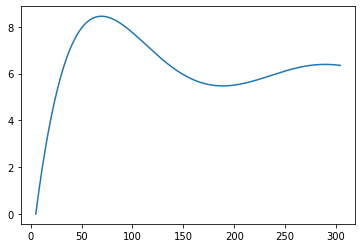

In [5]:
def lact_yield(data):
    r = pd.Series(index=data["lact day"], dtype=np.float)
    for day in data.loc[:,"lact day"]:
        w = 2 * ((day - 5)/(405 - 5)) - 1
        #leg_results = pd.Series(index=np.arange(1,6), name=day)
        
        #for x in range(0, 6):
        l = []
        #print(x)
            #if x == 0:
            #    leg_results[x] = 1
            #if x == 1:
            #    leg_results[x] = w * day_factor
            #if x == 2:
        #l.append(0.5 * (3 * w**2 - 1) * day_factor)
            #if x == 3:
        l.append(0.5 * (5 * w**3 - 3 * w) * np.sqrt((2 * 3 + 1)/2))
            #if x == 4:
        l.append(-(1/8) * (35 * w**4 - 30 * w**2 + 3) * np.sqrt((2 * 4 + 1)/2))
            #if x == 5:
        l.append((1/8) * (63 * w**5 - 70 * w**3 + 15 * w) * np.sqrt((2 * 5 + 1)/2))
        #print(leg_results)
        #leg_results = leg_results
        r[day] = np.sum(l)
    return r

data = pd.DataFrame(data=np.arange(5,305,1).reshape(-1,1), columns=["lact day"])
r = lact_yield(data)
r = r + abs(np.min(r))

plt.plot(r)
plt.savefig("../Vorlesungen/G05 Mathematik/TeX-Dateien Eike/11 Integrale/Laktationskurve.pgf")